In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import scipy.linalg
import scipy.signal
import matplotlib.pyplot as plt
import sys
from scipy.fftpack import dct, idct
sys.path.append(os.path.join('..','UTILS'))
# cosamp function is available at https://github.com/avirmaux/CoSaMP
plt.rcParams['figure.figsize'] = [24,8]
plt.rcParams.update({'font.size': 28})

In [9]:
def cosamp(Phi, u, s, epsilon=1e-10, max_iter=1000):
    """
    @Brief:  "CoSaMP: Iterative signal recovery from incomplete and inaccurate
             samples" by Deanna Needell & Joel Tropp

    @Input:  Phi - Sampling matrix
             u   - Noisy sample vector
             s   - Sparsity vector

    @Return: A s-sparse approximation "a" of the target signal
    """
    max_iter -= 1 # Correct the while loop
    num_precision = 1e-12
    a = np.zeros(Phi.shape[1])
    v = u
    iter = 0
    halt = False
    while not halt:
        iter += 1
        print("Iteration {}\r".format(iter))
        
        y = abs(np.dot(np.transpose(Phi), v))
        Omega = [i for (i, val) in enumerate(y) if val > np.sort(y)[::-1][2*s] and val > num_precision] # quivalent to below
        #Omega = np.argwhere(y >= np.sort(y)[::-1][2*s] and y > num_precision)
        T = np.union1d(Omega, a.nonzero()[0])
        #T = np.union1d(Omega, T)
        b = np.dot( np.linalg.pinv(Phi[:,T]), u )
        igood = (abs(b) > np.sort(abs(b))[::-1][s]) & (abs(b) > num_precision)
        T = T[igood]
        a[T] = b[igood]
        v = u - np.dot(Phi[:,T], b[igood])
        
        halt = np.linalg.norm(v)/np.linalg.norm(u) < tol or \
               iter > max_iter
        
    return a

In [6]:
## Generate signal, DCT of signal

n = 4096 # points in high resolution signal
t = np.linspace(0,1,n)
x = np.cos(2 * 97 * np.pi * t) + 0.35*np.cos(2 * 877 * np.pi * t) + 0.5*np.cos(2*600*np.pi*t) + 0.7*np.cos(2*350*np.pi*t)
xt = np.fft.fft(x) # Fourier transformed signal
PSD = xt * np.conj(xt) / n # Power spectral density



aquis = np.round((n-1) * np.random.rand(p)).astype(int)
y = x[aquis] # our compressed measurement from the random sampling

# Here {y} = [C]{x} = [C][Phi]{s}, where Phi is the inverse discrete cosine transform

Phi = scipy.fftpack.dct(np.eye(n), axis=0, norm='ortho')
CPhi = Phi[aquis,:]

# l1 minimization (through linear programming)
s = cosamp(CPhi, y, 10) # obtain the sparse vector through CoSaMP algorithm
xrec = scipy.fftpack.idct(s, axis=0, norm='ortho') # Reconstructed signal



figw, figh = 7.0, 5.0 # figure width and height
plt.figure(figsize=(figw, figh))
plt.plot(t, s)
plt.title('Sparse vector $s$')
plt.show()


# Visualize the compressed-sensing reconstruction signal
figw, figh = 7.0, 5.0 # figure width and height
plt.figure(figsize=(figw, figh))
plt.plot(t, x,    'b', label='Original signal')
plt.plot(t, xrec, 'r', label='Reconstructed signal')
plt.xlim(0.4, 0.5)
legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')
plt.show()


In [7]:
##### Randomly sample signal
m = 50 # num. random samples, m >= k*log(n/k)
perm = np.floor(np.random.rand(m) * n).astype(int)
y = x[perm]

In [10]:
## Solve compressed sensing problem
Psi = dct(np.identity(n)) # Build Psi
Theta = Psi[perm,:]       # Measure rows of Psi

s = cosamp(Theta,y,10,epsilon=1.e-10,max_iter=10) # CS via matching pursuit
xrecon = idct(s) # reconstruct full signal

Iteration 1


NameError: name 'tol' is not defined

<ipython-input-97-878d8c424e8c>:6: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(t,x,color='k',LineWidth=2,label='Señal completa')
<ipython-input-97-878d8c424e8c>:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(perm/n,y,color='r',marker='x',LineWidth=0,ms=12,mew=4,label='Captación')


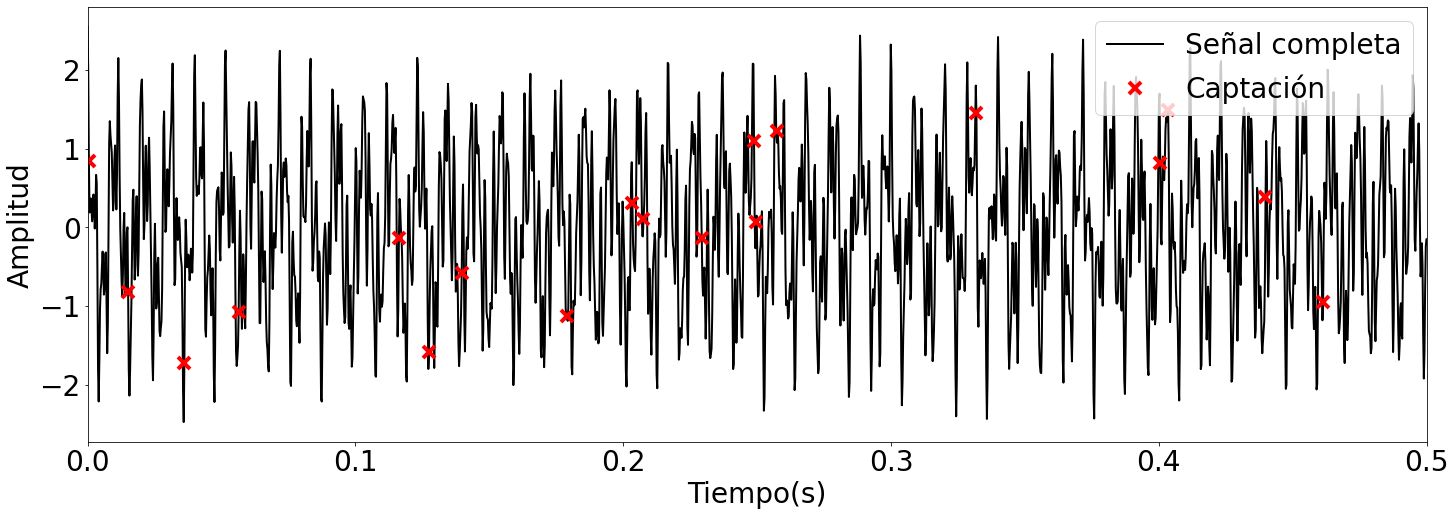

In [97]:
## Plot
freq = np.arange(n)
L = int(np.floor(n/2))

plt.plot(t,x,color='k',LineWidth=2,label='Señal completa')
plt.plot(perm/n,y,color='r',marker='x',LineWidth=0,ms=12,mew=4,label='Captación')
plt.xlim(0,0.5)
plt.xlabel('Tiempo(s)')
plt.ylabel('Amplitud')
plt.legend()
plt.show()

<ipython-input-98-93f2f7848889>:4: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  axs[0].plot(freq[:L],PSD[:L],color='k',LineWidth=2)
C:\Users\SE79065\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
<ipython-input-98-93f2f7848889>:8: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  axs[1].plot(t,xrecon,color='r',LineWidth=2)
<ipython-input-98-93f2f7848889>:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  axs[2].plot(freq[:L],PSDrecon[:L],color='r',LineWidth=2)
C:\Users\SE79065\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imag

(0.0, 1200.0)

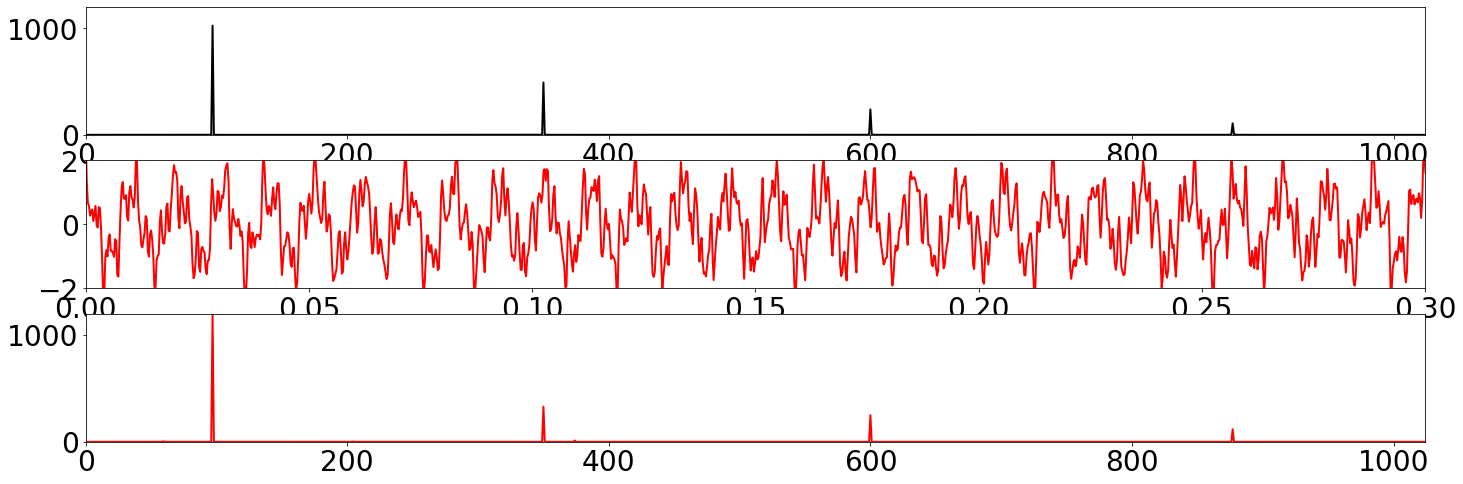

In [98]:
fig,axs = plt.subplots(3,1)
axs = axs.reshape(-1)

axs[0].plot(freq[:L],PSD[:L],color='k',LineWidth=2)
axs[0].set_xlim(0, 1024)
axs[0].set_ylim(0, 1200)

axs[1].plot(t,xrecon,color='r',LineWidth=2)
axs[1].set_xlim(0,0.3)
axs[1].set_ylim(-2, 2)


xtrecon = np.fft.fft(xrecon,n) # computes the (fast) discrete fourier transform
PSDrecon = xtrecon * np.conj(xtrecon)/n # Power spectrum (how much power in each freq)

axs[2].plot(freq[:L],PSDrecon[:L],color='r',LineWidth=2)
axs[2].set_xlim(0, 1024)
axs[2].set_ylim(0, 1200)